In [4]:
pip install torch torchvision torchaudio


     ---------------------------------------- 4.0/4.0 MB 8.3 MB/s eta 0:00:00
     ------------------------------------- 664.7/664.7 kB 13.9 MB/s eta 0:00:00
  Using cached torch-2.9.1-cp311-cp311-win_amd64.whl (111.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

In [2]:
train_path = "C:/Users/sagar/OneDrive/Desktop/dataset.dm/train"
test_path  = "C:/Users/sagar/OneDrive/Desktop/dataset.dm/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
test_ds  = datasets.ImageFolder(root=test_path,  transform=transform)
combined_ds = ConcatDataset([train_ds, test_ds])
loader = DataLoader(combined_ds, batch_size=32, shuffle=False)

y_true = np.array([label for _, label in train_ds.samples] +
                  [label for _, label in test_ds.samples])
print("Classes:", train_ds.classes)
print("Total images:", len(combined_ds))

Classes: ['airplanes', 'cars', 'ships']
Total images: 3582


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()
model.to(device)
features_list = []
def hook_fn(module, input, output):
    features_list.append(output.detach().cpu())
hook = model.layer4.register_forward_hook(hook_fn)
with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        model(images)
hook.remove()
print("Batches captured:", len(features_list))
print("First batch shape:", features_list[0].shape)
print("Feature extraction reference:",
      "https://kozodoi.me/blog/20210527/extracting-features")

Batches captured: 112
First batch shape: torch.Size([32, 512, 7, 7])
Feature extraction reference: https://kozodoi.me/blog/20210527/extracting-features


In [4]:
conv_features = torch.cat(features_list, dim=0)
X = conv_features.mean(dim=(2, 3)).numpy()
np.save("features.npy", X)
np.save("labels.npy", y_true)
print("Feature shape:", X.shape)

Feature shape: (3582, 512)


In [5]:
X = np.load("features.npy")
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)
print("Original shape:", X.shape)
print("2D shape:", X_2d.shape)
np.save("X_2d.npy", X_2d)
print("Saved X_2d.npy")

Original shape: (3582, 512)
2D shape: (3582, 2)
Saved X_2d.npy


KMeans clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]
KMeans++ clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]
BisectingKMeans clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]
Spectral(default) clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]
DBSCAN clusters: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Single link clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Complete link clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Average link clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Ward clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
the eps: 0.5 , min_samples: 9


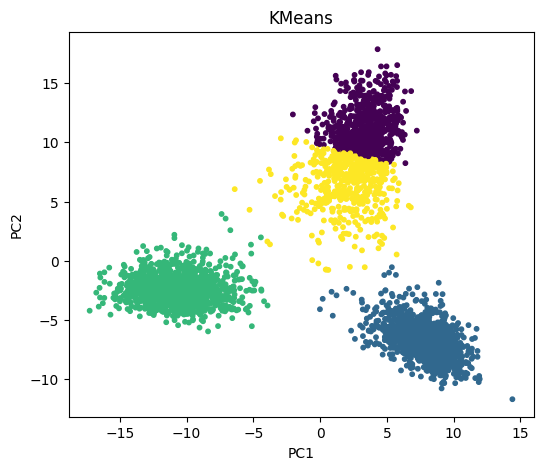

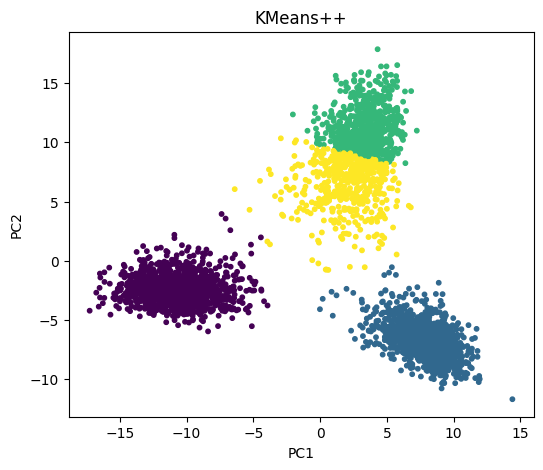

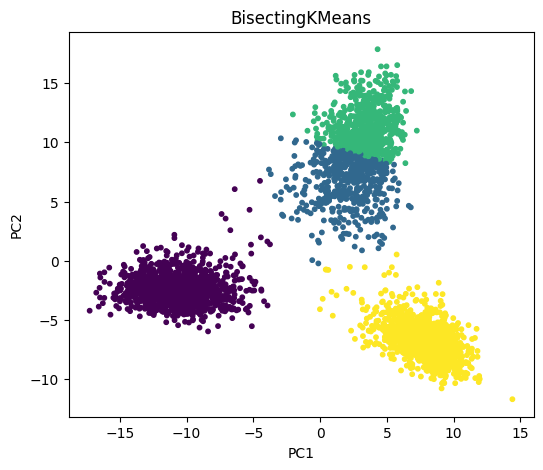

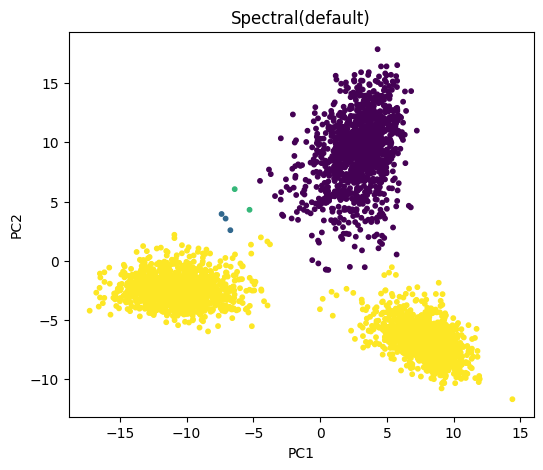

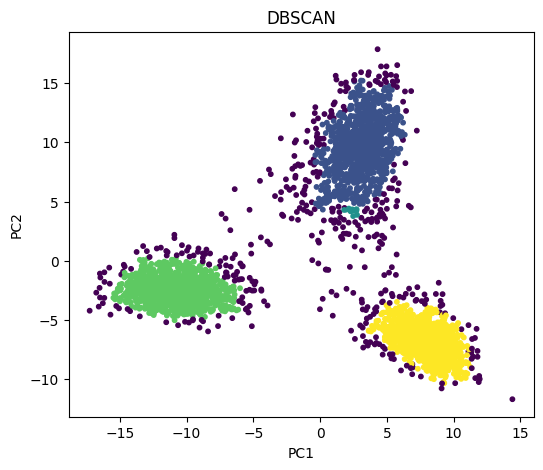

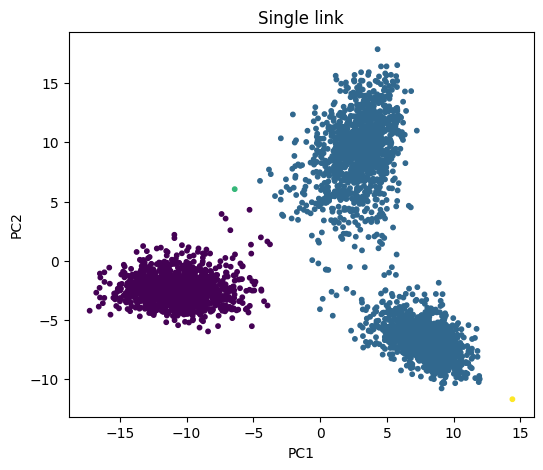

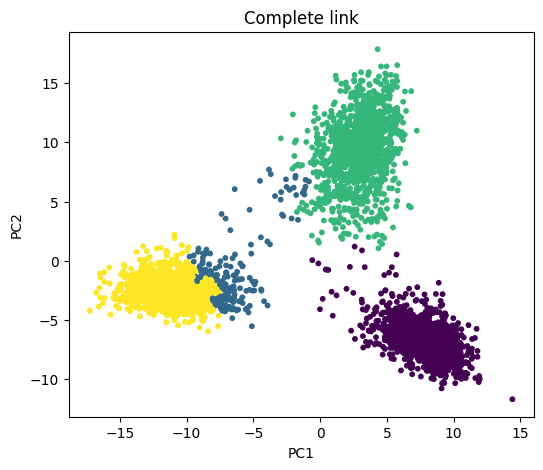

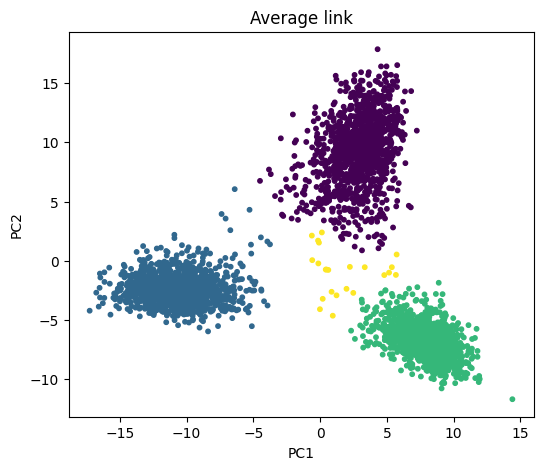

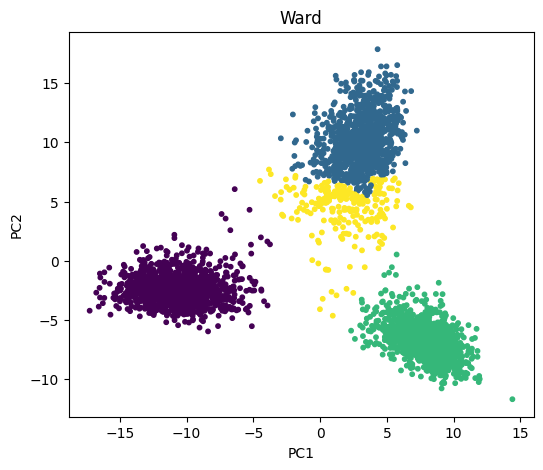

In [15]:
X_2d = np.load("X_2d.npy")
results = {}
results["KMeans"] = KMeans(n_clusters=4, init="random", random_state=42).fit_predict(X_2d)
results["KMeans++"] = KMeans(n_clusters=4, init="k-means++", random_state=42).fit_predict(X_2d)
results["BisectingKMeans"] = BisectingKMeans(n_clusters=4, init="random", random_state=42).fit_predict(X_2d)
results["Spectral(default)"] = SpectralClustering(n_clusters=4).fit_predict(X_2d)
eps_used = 0.5
min_samples_used = 9
results["DBSCAN"] = DBSCAN(eps=eps_used, min_samples=min_samples_used).fit_predict(X_2d)
results["Single link"] = AgglomerativeClustering(n_clusters=4, linkage="single").fit_predict(X_2d)
results["Complete link"] = AgglomerativeClustering(n_clusters=4, linkage="complete").fit_predict(X_2d)
results["Average link"] = AgglomerativeClustering(n_clusters=4, linkage="average").fit_predict(X_2d)
results["Ward"] = AgglomerativeClustering(n_clusters=4, linkage="ward").fit_predict(X_2d)
for name, labels in results.items():
    print(name, "clusters:", sorted(set(labels)))
print("the eps:", eps_used, ", min_samples:", min_samples_used)
for name, labels in results.items():
    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10)
    plt.title(name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


In [ ]:
#What are the eps and min samples parameter values you used to get 4 cluster?
eps = 0.5, min_samples = 9

In [17]:
y_true = np.load("labels.npy")
print("Fowlkes–Mallows Index values:\n")
fmi_km_random = fowlkes_mallows_score(y_true, results["KMeans"])
print("KMeans:", fmi_km_random)
fmi_km_plus = fowlkes_mallows_score(y_true, results["KMeans++"])
print("k-means++:", fmi_km_plus)
fmi_bisect = fowlkes_mallows_score(y_true, results["BisectingKMeans"])
print("Bisecting KMeans:", fmi_bisect)
fmi_spectral = fowlkes_mallows_score(y_true, results["Spectral(default)"])
print("Spectral Clustering:", fmi_spectral)
fmi_dbscan = fowlkes_mallows_score(y_true, results["DBSCAN"])
print("DBSCAN:", fmi_dbscan)
fmi_single = fowlkes_mallows_score(y_true, results["Single link"])
print("Single Link:", fmi_single)
fmi_complete = fowlkes_mallows_score(y_true, results["Complete link"])
print("Complete Link:", fmi_complete)
fmi_average = fowlkes_mallows_score(y_true, results["Average link"])
print("Average Link:", fmi_average)
fmi_ward = fowlkes_mallows_score(y_true, results["Ward"])
print("Ward:", fmi_ward)


Fowlkes–Mallows Index values:

KMeans: 0.9087291653119546
k-means++: 0.9087291653119546
Bisecting KMeans: 0.9070623210097057
Spectral Clustering: 0.7684747055030242
DBSCAN: 0.8746088533943301
Single Link: 0.7722342858738213
Complete Link: 0.9422967937048431
Average Link: 0.9880108741053425
Ward: 0.9412984684917779


In [18]:
X_2d = np.load("X_2d.npy")
print("Silhouette Coefficient values:\n")
sil_km_random = silhouette_score(X_2d, results["KMeans"])
print("KMeans (Random):", sil_km_random)
sil_km_plus = silhouette_score(X_2d, results["KMeans++"])
print("KMeans (k-means++):", sil_km_plus)
sil_bisect = silhouette_score(X_2d, results["BisectingKMeans"])
print("Bisecting KMeans:", sil_bisect)
sil_spectral = silhouette_score(X_2d, results["Spectral(default)"])
print("Spectral Clustering:", sil_spectral)
labels_dbscan = results["DBSCAN"]
labels = results["DBSCAN"]
mask = labels != -1
if len(set(labels[mask])) > 1:
    sil_dbscan = silhouette_score(X_2d[mask], labels[mask])
    print("DBSCAN silhouette (excluding noise):", sil_dbscan)
else:
    print("DBSCAN silhouette (excluding noise): NA")
sil_single = silhouette_score(X_2d, results["Single link"])
print("Single Link:", sil_single)
sil_complete = silhouette_score(X_2d, results["Complete link"])
print("Complete Link:", sil_complete)
sil_average = silhouette_score(X_2d, results["Average link"])
print("Average Link:", sil_average)
sil_ward = silhouette_score(X_2d, results["Ward"])
print("Ward:", sil_ward)

Silhouette Coefficient values:

KMeans (Random): 0.6740642189979553
KMeans (k-means++): 0.6740642189979553
Bisecting KMeans: 0.6732671856880188
Spectral Clustering: 0.1796562522649765
DBSCAN silhouette (excluding noise): 0.659974992275238
Single Link: 0.15674588084220886
Complete Link: 0.6505136489868164
Average Link: 0.6599839925765991
Ward: 0.6675320863723755


In [20]:
fmi_scores = {}
for name, labels in results.items():
    fmi_scores[name] = fowlkes_mallows_score(y_true, labels)
fmi_rank = sorted(fmi_scores.items(), key=lambda x: x[1], reverse=True)
print("The Ranking by Fowlkes-Mallows Index from Best to Worst:")
for i, (name, score) in enumerate(fmi_rank, 1):
    print(i, name)

The Ranking by Fowlkes-Mallows Index from Best to Worst:
1 Average link
2 Complete link
3 Ward
4 KMeans
5 KMeans++
6 BisectingKMeans
7 DBSCAN
8 Single link
9 Spectral(default)


In [21]:
sil_scores = {}
for name, labels in results.items():
    if name == "DBSCAN":
        mask = labels != -1
        if len(set(labels[mask])) > 1:
            sil_scores[name] = silhouette_score(X_2d[mask], labels[mask])
    else:
        if len(set(labels)) > 1:
            sil_scores[name] = silhouette_score(X_2d, labels)
sil_rank = sorted(sil_scores.items(), key=lambda x: x[1], reverse=True)
print("The Ranking by Silhouette Coefficient from Best to Worst:")
for i, (name, _) in enumerate(sil_rank, 1):
    print(i, name)


The Ranking by Silhouette Coefficient from Best to Worst:
1 KMeans
2 KMeans++
3 BisectingKMeans
4 Ward
5 Average link
6 DBSCAN
7 Complete link
8 Spectral(default)
9 Single link
